<a href="https://colab.research.google.com/github/juanpblgomez/mentoria-diplodatos-2024-analisis-cursos-previsionales/blob/main/ayvd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctico 1 - Análisis y Visualización de Datos

Trabajaremos sobre los datos anonimizados de compras de una plataforma de cursos onlines. Exploraremos las distintas fuentes de datos y haremos un análisis descriptivo y visual de los datos para entender cómo están distribuidas las ventas.

El dataset está constituido por tres bases: clientes, ventas y contactos. Hay diversos análisis que se pueden hacer a partir de las mismas: segmentación de clientes, análisis de texto de las consultas, análisis de series de tiempo de las ventas, etc.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy
import pandas as pd
import seaborn
import requests
from datetime import datetime, timedelta

## Lectura de los datasets

Funcion para leer los datos de Github

In [3]:
def read_from_raw(github_url):
  raw_url = github_url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")
  return pd.read_csv(raw_url, encoding = "ISO-8859-1")

Carga del set de datos contactos

In [4]:
df_contacts = read_from_raw('https://github.com/juanpblgomez/mentoria-diplodatos-2024-analisis-cursos-previsionales/blob/main/datos/contacts_anon.csv')
df_contacts[:3]

,id,fecha,nombre,email,genero,asunto,mensaje
0,80242452935422199706,16/03/2024 14:55:28,Dani Castellanos Briones,dani.castellanos.briones2358@hotmail.com,M,Consulta general,. quisiera saber si existe algun simulador del...
1,15409661513166318845,13/03/2024 16:13:09,Apolinar Jimenez Teruel,apolinar.jimenez.teruel6338@gmail.com,M,Consulta general,no puedo ver los videos del curso. necesito ayuda
2,67687345747217393942,12/03/2024 18:47:42,Evangelina Clotilde Requena Sans,evangelina.clotilde.requena.sans5853@gmail.com,F,Consulta general,"hola, me surge una duda de la ley . mujer de a..."


Carga del set de datos customers

In [5]:
df_customers = read_from_raw('https://github.com/juanpblgomez/mentoria-diplodatos-2024-analisis-cursos-previsionales/blob/main/datos/customers_anon.csv')
df_customers[:3]

,id,nombre,email,genero
0,87383708928538182091,Sancho Quesada,sancho.quesada631@gmail.com,M
1,90963905505013869370,Rosario Donoso,rosario.donoso4687@hotmail.com,F
2,36171761627209661626,Dani Castellanos Briones,dani.castellanos.briones2358@hotmail.com,M


Carga del set de datos orders

In [6]:
df_orders = read_from_raw('https://github.com/juanpblgomez/mentoria-diplodatos-2024-analisis-cursos-previsionales/blob/main/datos/orders_anon.csv')
df_orders[:3]

,número,Fecha,moneda,monto total,cant. de productos,estado del pago,medio de pago,estado de la entrega,forma de entrega,envío: dirección,envío: código postal,producto: código / sku,producto: cantidad,producto: precio,código país,código área,nombre,email,producto,codigo_promocional
0,5285,17/03/2024 03:29:27,ARS,20280.0,1,Pagado,Mercadopago,NaN,NaN,NaN,NaN,NaN,1,20280.0,54.0,NaN,Sancho Quesada,sancho.quesada631@gmail.com,Curso 2,NaN
1,5284,16/03/2024 14:33:27,ARS,20280.0,1,Pagado,Mercadopago,NaN,NaN,NaN,NaN,NaN,1,20280.0,54.0,297.0,Dani Castellanos Briones,dani.castellanos.briones2358@hotmail.com,Curso 2,NaN
2,5283,15/03/2024 19:21:18,ARS,20280.0,1,Pendiente,Mercadopago,NaN,NaN,NaN,NaN,NaN,1,20280.0,54.0,351.0,María Saldaña,maria.saldana6060@gmail.com,Curso 2,NaN


## Analisis de series de tiempo de las ventas

Comenzaremos el analisis determinando si existen valores faltantes en el dataset, primero haremos un análisis de valores nulos. Luego, dependiendo de los resultados, consideraremos las posibles causas y cómo tratar estos valores faltantes.

**1. Verificar los valores faltantes**

In [7]:
missing_values = df_orders.isnull().sum()
missing_values_percentage = (missing_values / len(df_orders)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_values_percentage})
print(missing_data.sort_values(by='Missing Values', ascending=False))


                        Missing Values  Percentage
envío: código postal              5254  100.000000
estado de la entrega              5254  100.000000
producto: código / sku            5254  100.000000
envío: dirección                  5254  100.000000
forma de entrega                  5254  100.000000
codigo_promocional                5122   97.487628
código área                       1320   25.123715
código país                          7    0.133232
medio de pago                        0    0.000000
estado del pago                      0    0.000000
cant. de productos                   0    0.000000
monto total                          0    0.000000
Fecha                                0    0.000000
moneda                               0    0.000000
producto: cantidad                   0    0.000000
producto: precio                     0    0.000000
nombre                               0    0.000000
email                                0    0.000000
producto                       

**2. Posibles causas de valores faltantes:**

* Errores durante la recolección de datos.
* Información no disponible en el momento de la recolección.
* Problemas en la importación de datos.
* Falta de voluntad de los usuarios

**3. Tratamiento de valores faltantes:**

* **Eliminar filas/columnas**: Si hay muchas filas o columnas con valores faltantes, puedes considerar eliminarlas.
* **Imputación**: Se vera en Analisis y curacion de datos

Procederemos a eliminar aquellas columnas que carecen de mas del 95% de sus datos

In [37]:
columns_to_drop = ['envío: código postal', 'estado de la entrega', 'producto: código / sku',
                   'envío: dirección', 'forma de entrega', 'codigo_promocional']
df_orders = df_orders.drop(columns=columns_to_drop)
print(df_orders.columns)


Index(['número', 'Fecha', 'moneda', 'monto total', 'cant. de productos',
       'estado del pago', 'medio de pago', 'producto: cantidad',
       'producto: precio', 'código país', 'código área', 'nombre', 'email',
       'producto'],
      dtype='object')


Para nuestro analisis de serie de tiempo consideramos como variables esenciales a la columna **Fecha** y **Monto Total**

Para ello, primero necesitamos asegurarnos de que las fechas y los montos de las ventas están en el formato adecuado.

Por lo tanto vamos a seguir los siguientes pasos:


In [38]:
exchange_rates_df = read_from_raw('https://github.com/juanpblgomez/mentoria-diplodatos-2024-analisis-cursos-previsionales/blob/main/datos/tipos-de-cambio-historicos.csv')
exchange_rates_df[:3]

,Fecha,USD
0,2021-01-01,84.145
1,2021-01-02,84.145
2,2021-01-03,84.145


In [39]:
df_orders['Fecha'] = pd.to_datetime(df_orders['Fecha'], format='%d/%m/%Y %H:%M:%S').dt.date
exchange_rates_df['Fecha'] = pd.to_datetime(exchange_rates_df['Fecha'], format='%Y-%m-%d').dt.date

df_merged = pd.merge(df_orders, exchange_rates_df, on='Fecha', how='left')

# Calcular los montos en USD
df_merged['monto total USD'] = df_merged['monto total'] / df_merged['USD']
df_merged['monto total USD'] = df_merged['monto total USD'].round(2)

# Mostrar las primeras filas para verificar la nueva columna
print(df_merged[['Fecha', 'monto total', 'USD', 'monto total USD']].head())


        Fecha  monto total     USD  monto total USD
0  2024-03-17      20280.0  850.75            23.84
1  2024-03-16      20280.0  850.75            23.84
2  2024-03-15      20280.0  850.75            23.84
3  2024-03-15      86658.0  850.75           101.86
4  2024-03-15      86658.0  850.75           101.86


**Convertiremos las columnas de fechas al tipo de datos datetime.**

In [40]:
#df_orders['Fecha'] = pd.to_datetime(df_orders['Fecha'], format='%d/%m/%Y %H:%M:%S')

**Agrupamos los datos por fecha para obtener las ventas totales por día.**

In [43]:
#sales_time_series = df_orders.groupby(df_orders['Fecha'].dt.date)['monto total'].sum()
sales_time_series = df_merged.groupby(df_merged['Fecha'])['monto total USD'].sum()

**Visualizar la serie de tiempo de las ventas.**

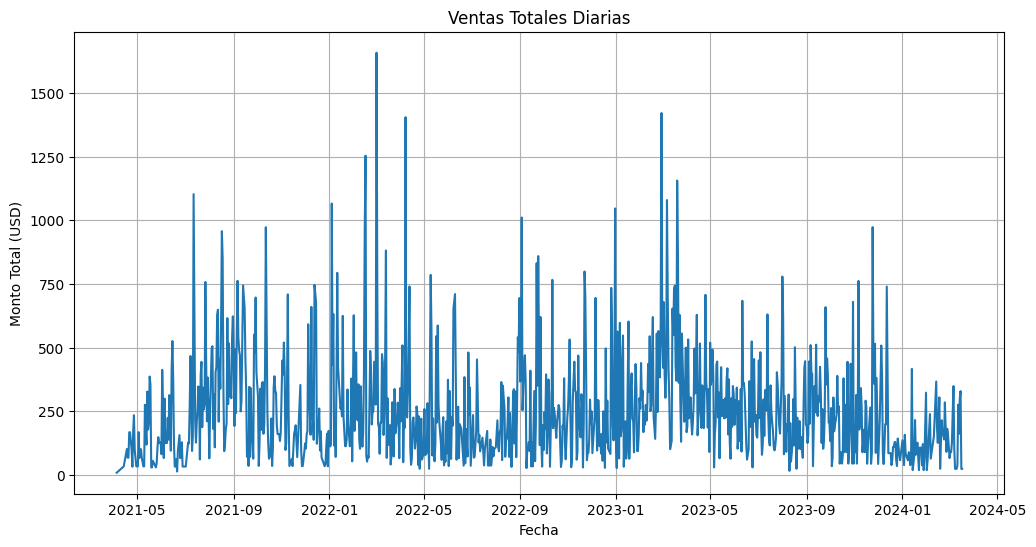

In [45]:
plt.figure(figsize=(12, 6))
sales_time_series.plot()
plt.title('Ventas Totales Diarias')
plt.xlabel('Fecha')
plt.ylabel('Monto Total (USD)')
plt.grid(True)
plt.show()

**Visualizar los componentes de tendencia y estacionalidad:**

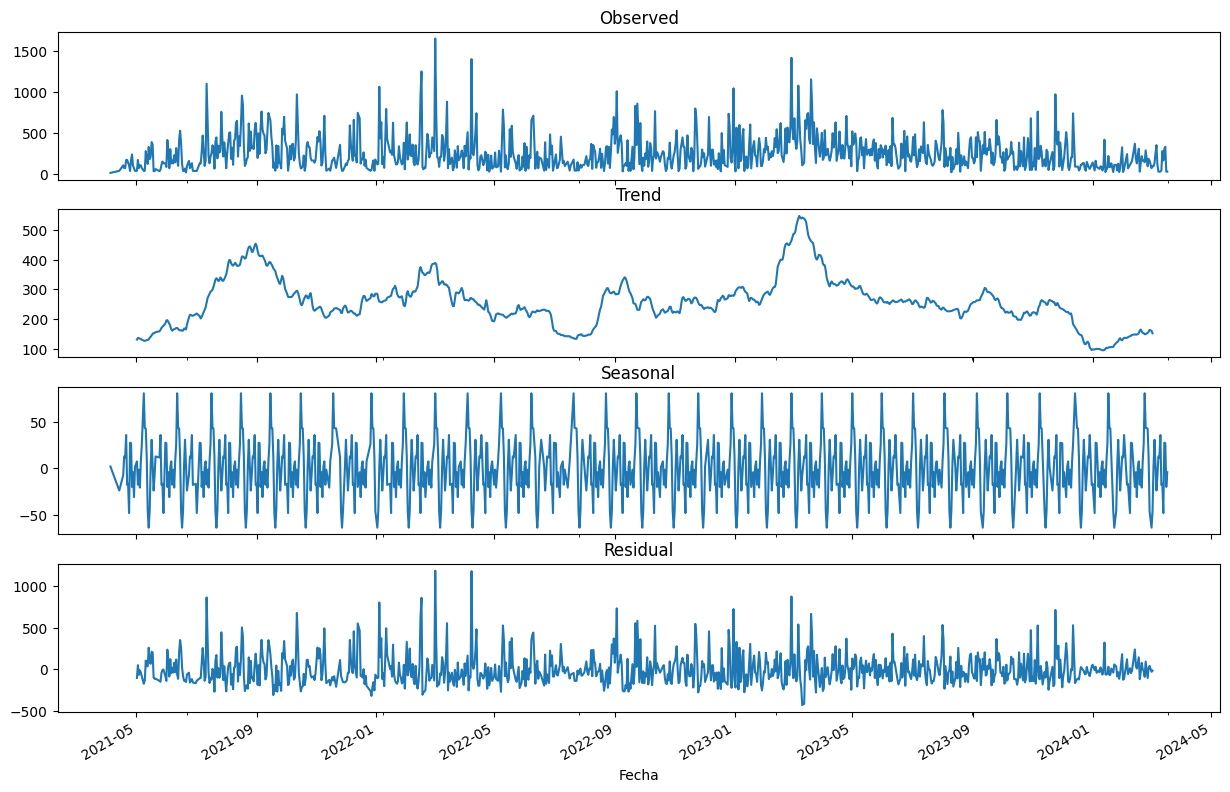

In [46]:
# Convertir el índice a datetime para asegurar compatibilidad
sales_time_series.index = pd.to_datetime(sales_time_series.index)

# Descomposición de la serie de tiempo
decomposition = seasonal_decompose(sales_time_series, model='additive', period=30)

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residual')
plt.show()